## Thread: Circuits 사전 준비 - InceptionV1 구현

### 1. Inception Module의 아이디어
- **다양한 크기의 필터를 병렬로 사용**: 1x1, 3x3, 5x5 conv와 max pooling
- **1x1 convolution으로 차원 축소**: 계산량 대폭 감소 (bottleneck design)
- **Multi-scale feature extraction**: 다양한 크기의 패턴을 동시에 포착

### 2. 네트워크 구조의 특징
- **22개 층의 깊은 네트워크**: 당시로서는 매우 깊음
- **보조 분류기 (Auxiliary Classifiers)**: gradient vanishing 문제 해결
- **Global Average Pooling**: FC layer 대신 사용으로 overfitting 감소

### 3. 계산 효율성
- 1x1 conv를 통한 차원 축소로 파라미터 수 대폭 감소
- 다양한 크기의 receptive field를 효율적으로 구현

### 4. Thread: Circuits에서 주목할 점들
- **Feature Detector의 형성**: 각 Inception 모듈이 어떤 feature를 감지하는지
- **Information Flow**: 다양한 branch들이 어떻게 정보를 처리하고 결합하는지
- **Hierarchical Representation**: 층이 깊어질수록 더 복잡한 feature 학습

### 5. Interpretability 관점에서의 분석 포인트
1. 각 Inception 모듈의 branch별 역할 분석
2. 1x1 conv의 차원 축소 효과와 feature 선택
3. 보조 분류기가 중간층 representation에 미치는 영향
4. 다양한 scale의 feature가 어떻게 결합되는지

In [ ]:
# 필수 패키지 설치
%pip install torch torchvision matplotlib torchsummary

### Import

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torchsummary import summary

### Inception Module

In [4]:
class InceptionModule(nn.Module):
    """
    InceptionV1의 핵심 모듈
    - 1x1, 3x3, 5x5 conv와 max pooling을 병렬로 수행
    - 1x1 conv로 차원 축소(dimension reduction) 수행
    """
    def __init__(self, in_channels, ch1x1, ch3x3_reduce, ch3x3, ch5x5_reduce, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()

        # 1x1 convolution branch
        self.branch1 = nn.Conv2d(in_channels, ch1x1, kernel_size=1)

        # 3x3 convolution branch (with 1x1 reduction)
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch3x3_reduce, ch3x3, kernel_size=3, padding=1)
        )

        # 5x5 convolution branch (with 1x1 reduction)
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5_reduce, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch5x5_reduce, ch5x5, kernel_size=5, padding=2)
        )

        # Max pooling branch (with 1x1 projection)
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = F.relu(self.branch1(x))
        branch2 = F.relu(self.branch2(x))
        branch3 = F.relu(self.branch3(x))
        branch4 = F.relu(self.branch4(x))

        # Concatenate along channel dimension
        outputs = torch.cat([branch1, branch2, branch3, branch4], dim=1)
        return outputs

### Auxiliary Classifier

In [5]:
class AuxiliaryClassifier(nn.Module):
    """
    InceptionV1의 보조 분류기
    - 중간 layer에서 gradient vanishing 문제를 해결하기 위해 사용
    - Training 시에만 사용되고 inference에서는 제거
    """
    def __init__(self, in_channels, num_classes):
        super(AuxiliaryClassifier, self).__init__()

        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.conv = nn.Conv2d(in_channels, 128, kernel_size=1)
        self.fc1 = nn.Linear(128 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)
        self.dropout = nn.Dropout(0.7)

    def forward(self, x):
        x = self.avgpool(x)
        x = F.relu(self.conv(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

### InceptionV1 Model

In [6]:
class InceptionV1(nn.Module):
    """
    InceptionV1 (GoogleNet) 전체 구현
    - 22개 층의 깊은 네트워크
    - 9개의 Inception 모듈
    - 2개의 보조 분류기
    """
    def __init__(self, num_classes=1000, aux_logits=True):
        super(InceptionV1, self).__init__()
        self.aux_logits = aux_logits

        # Initial convolution layers
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.conv3 = nn.Conv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Inception modules
        self.inception3a = InceptionModule(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception4a = InceptionModule(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionModule(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionModule(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionModule(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionModule(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.inception5a = InceptionModule(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionModule(832, 384, 192, 384, 48, 128, 128)

        # Auxiliary classifiers (used during training)
        if self.aux_logits:
            self.aux1 = AuxiliaryClassifier(512, num_classes)  # after inception4a
            self.aux2 = AuxiliaryClassifier(528, num_classes)  # after inception4d

        # Final layers
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        # Initial layers
        x = F.relu(self.conv1(x))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.maxpool2(x)

        # Inception 3
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        # Inception 4
        x = self.inception4a(x)
        aux1 = None
        if self.aux_logits and self.training:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        aux2 = None
        if self.aux_logits and self.training:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)

        # Inception 5
        x = self.inception5a(x)
        x = self.inception5b(x)

        # Final classification
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = self.fc(x)

        if self.aux_logits and self.training:
            return x, aux1, aux2
        else:
            return x

### 모델 구조 확인

In [7]:
# 모델 생성 및 테스트
model = InceptionV1(num_classes=1000, aux_logits=True)

# 모델 파라미터 개수 확인
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

# 테스트 입력으로 forward pass 확인
test_input = torch.randn(1, 3, 224, 224)
model.eval()  # evaluation mode (보조 분류기 비활성화)

with torch.no_grad():
    output = model(test_input)
    print(f"Output shape: {output.shape}")

# Training mode에서의 출력 (보조 분류기 포함)
model.train()
with torch.no_grad():
    main_out, aux1_out, aux2_out = model(test_input)
    print(f"Main output shape: {main_out.shape}")
    print(f"Aux1 output shape: {aux1_out.shape}")
    print(f"Aux2 output shape: {aux2_out.shape}")

Total parameters: 13,378,280
Trainable parameters: 13,378,280
Output shape: torch.Size([1, 1000])
Main output shape: torch.Size([1, 1000])
Aux1 output shape: torch.Size([1, 1000])
Aux2 output shape: torch.Size([1, 1000])


In [8]:
# Inception 모듈 하나만 따로 분석해보기
inception_module = InceptionModule(192, 64, 96, 128, 16, 32, 32)

test_input_inception = torch.randn(1, 192, 28, 28)  # 예시 입력

# 각 branch별 출력 확인
with torch.no_grad():
    # Branch 1: 1x1 conv
    branch1_out = F.relu(inception_module.branch1(test_input_inception))

    # Branch 2: 1x1 -> 3x3 conv
    branch2_out = F.relu(inception_module.branch2(test_input_inception))

    # Branch 3: 1x1 -> 5x5 conv
    branch3_out = F.relu(inception_module.branch3(test_input_inception))

    # Branch 4: MaxPool -> 1x1 conv
    branch4_out = F.relu(inception_module.branch4(test_input_inception))

    # 최종 concatenated 출력
    final_out = inception_module(test_input_inception)

print("=== Inception Module Analysis ===")
print(f"Input shape: {test_input_inception.shape}")
print(f"Branch 1 (1x1) output: {branch1_out.shape}")
print(f"Branch 2 (3x3) output: {branch2_out.shape}")
print(f"Branch 3 (5x5) output: {branch3_out.shape}")
print(f"Branch 4 (pool) output: {branch4_out.shape}")
print(f"Final concatenated output: {final_out.shape}")

# 채널 수 확인
total_channels = branch1_out.shape[1] + branch2_out.shape[1] + branch3_out.shape[1] + branch4_out.shape[1]
print(f"Total output channels: {total_channels}")

=== Inception Module Analysis ===
Input shape: torch.Size([1, 192, 28, 28])
Branch 1 (1x1) output: torch.Size([1, 64, 28, 28])
Branch 2 (3x3) output: torch.Size([1, 128, 28, 28])
Branch 3 (5x5) output: torch.Size([1, 32, 28, 28])
Branch 4 (pool) output: torch.Size([1, 32, 28, 28])
Final concatenated output: torch.Size([1, 256, 28, 28])
Total output channels: 256


In [9]:
# 모델의 각 단계별 feature map 크기 추적
def trace_model_shapes(model, input_tensor):
    """모델의 각 단계별 출력 크기를 추적"""
    model.eval()
    x = input_tensor

    print("=== InceptionV1 Forward Pass Shape Tracing ===")
    print(f"Input: {x.shape}")

    # Initial layers
    x = F.relu(model.conv1(x))
    print(f"After conv1 (7x7, stride=2): {x.shape}")

    x = model.maxpool1(x)
    print(f"After maxpool1: {x.shape}")

    x = F.relu(model.conv2(x))
    print(f"After conv2 (1x1): {x.shape}")

    x = F.relu(model.conv3(x))
    print(f"After conv3 (3x3): {x.shape}")

    x = model.maxpool2(x)
    print(f"After maxpool2: {x.shape}")

    # Inception modules
    x = model.inception3a(x)
    print(f"After inception3a: {x.shape}")

    x = model.inception3b(x)
    print(f"After inception3b: {x.shape}")

    x = model.maxpool3(x)
    print(f"After maxpool3: {x.shape}")

    x = model.inception4a(x)
    print(f"After inception4a: {x.shape}")

    x = model.inception4b(x)
    print(f"After inception4b: {x.shape}")

    x = model.inception4c(x)
    print(f"After inception4c: {x.shape}")

    x = model.inception4d(x)
    print(f"After inception4d: {x.shape}")

    x = model.inception4e(x)
    print(f"After inception4e: {x.shape}")

    x = model.maxpool4(x)
    print(f"After maxpool4: {x.shape}")

    x = model.inception5a(x)
    print(f"After inception5a: {x.shape}")

    x = model.inception5b(x)
    print(f"After inception5b: {x.shape}")

    x = model.avgpool(x)
    print(f"After global avgpool: {x.shape}")

    x = torch.flatten(x, 1)
    print(f"After flatten: {x.shape}")

    return x

# 실행
test_input = torch.randn(1, 3, 224, 224)
with torch.no_grad():
    _ = trace_model_shapes(model, test_input)

=== InceptionV1 Forward Pass Shape Tracing ===
Input: torch.Size([1, 3, 224, 224])
After conv1 (7x7, stride=2): torch.Size([1, 64, 112, 112])
After maxpool1: torch.Size([1, 64, 56, 56])
After conv2 (1x1): torch.Size([1, 64, 56, 56])
After conv3 (3x3): torch.Size([1, 192, 56, 56])
After maxpool2: torch.Size([1, 192, 28, 28])
After inception3a: torch.Size([1, 256, 28, 28])
After inception3b: torch.Size([1, 480, 28, 28])
After maxpool3: torch.Size([1, 480, 14, 14])
After inception4a: torch.Size([1, 512, 14, 14])
After inception4b: torch.Size([1, 512, 14, 14])
After inception4c: torch.Size([1, 512, 14, 14])
After inception4d: torch.Size([1, 528, 14, 14])
After inception4e: torch.Size([1, 832, 14, 14])
After maxpool4: torch.Size([1, 832, 7, 7])
After inception5a: torch.Size([1, 832, 7, 7])
After inception5b: torch.Size([1, 1024, 7, 7])
After global avgpool: torch.Size([1, 1024, 1, 1])
After flatten: torch.Size([1, 1024])


---

### 실제 모델 성능 테스트

In [10]:
# 데이터셋 로드 및 전처리
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# CIFAR-10으로 테스트 (더 작은 이미지지만 빠른 테스트용)
# ImageNet-style 전처리를 적용
transform = transforms.Compose([
    transforms.Resize(224),  # InceptionV1은 224x224 입력을 받음
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                        std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

# CIFAR-10 데이터셋 로드
print("Loading CIFAR-10 dataset...")
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

# CIFAR-10 클래스 이름
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

print(f"Training samples: {len(trainset)}")
print(f"Test samples: {len(testset)}")
print(f"Classes: {classes}")

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:06<00:00, 26.8MB/s]


Training samples: 50000
Test samples: 10000
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
# CIFAR-10용 모델 생성 (10개 클래스)
model_cifar = InceptionV1(num_classes=10, aux_logits=True)

# 또는 사전 훈련된 GoogleNet 사용 (Transfer Learning)
print("Loading pretrained GoogleNet...")
pretrained_model = torchvision.models.googlenet(pretrained=True)

# CIFAR-10에 맞게 마지막 분류기 수정
pretrained_model.fc = nn.Linear(pretrained_model.fc.in_features, 10)

# GPU 사용 가능하면 GPU로 이동
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model_cifar = model_cifar.to(device)
pretrained_model = pretrained_model.to(device)

print("Models ready for training/testing!")

In [12]:
# 모델 추론 및 성능 평가 함수
def evaluate_model(model, dataloader, device, model_name="Model"):
    """모델의 성능을 평가하고 결과를 반환"""
    model.eval()
    correct = 0
    total = 0
    class_correct = [0] * 10
    class_total = [0] * 10

    all_predictions = []
    all_labels = []

    print(f"Evaluating {model_name}...")

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(dataloader):
            data, target = data.to(device), target.to(device)

            # Forward pass
            outputs = model(data)
            if isinstance(outputs, tuple):  # 보조 분류기가 있는 경우
                outputs = outputs[0]

            _, predicted = torch.max(outputs, 1)

            # 전체 정확도 계산
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # 클래스별 정확도 계산
            c = (predicted == target).squeeze()
            for i in range(target.size(0)):
                label = target[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

            # 진행 상황 출력
            if batch_idx % 100 == 0:
                print(f'Batch {batch_idx}/{len(dataloader)} processed')

    # 결과 정리
    overall_accuracy = 100 * correct / total
    class_accuracies = [100 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0
                       for i in range(10)]

    return {
        'overall_accuracy': overall_accuracy,
        'class_accuracies': class_accuracies,
        'predictions': all_predictions,
        'labels': all_labels
    }

# 사전 훈련된 모델로 테스트 (몇 개 배치만)
print("Testing pretrained model on a few batches...")
test_iter = iter(testloader)
sample_results = []

pretrained_model.eval()
for i in range(3):  # 3개 배치만 테스트
    data, target = next(test_iter)
    data, target = data.to(device), target.to(device)

    with torch.no_grad():
        outputs = pretrained_model(data)
        _, predicted = torch.max(outputs, 1)

        batch_accuracy = (predicted == target).float().mean()
        sample_results.append(batch_accuracy.item())

        print(f"Batch {i+1} accuracy: {batch_accuracy:.4f}")

print(f"Average accuracy on sample batches: {np.mean(sample_results):.4f}")

Testing pretrained model on a few batches...
Batch 1 accuracy: 0.0312
Batch 2 accuracy: 0.0625
Batch 3 accuracy: 0.1562
Average accuracy on sample batches: 0.0833


Visualizing predictions...


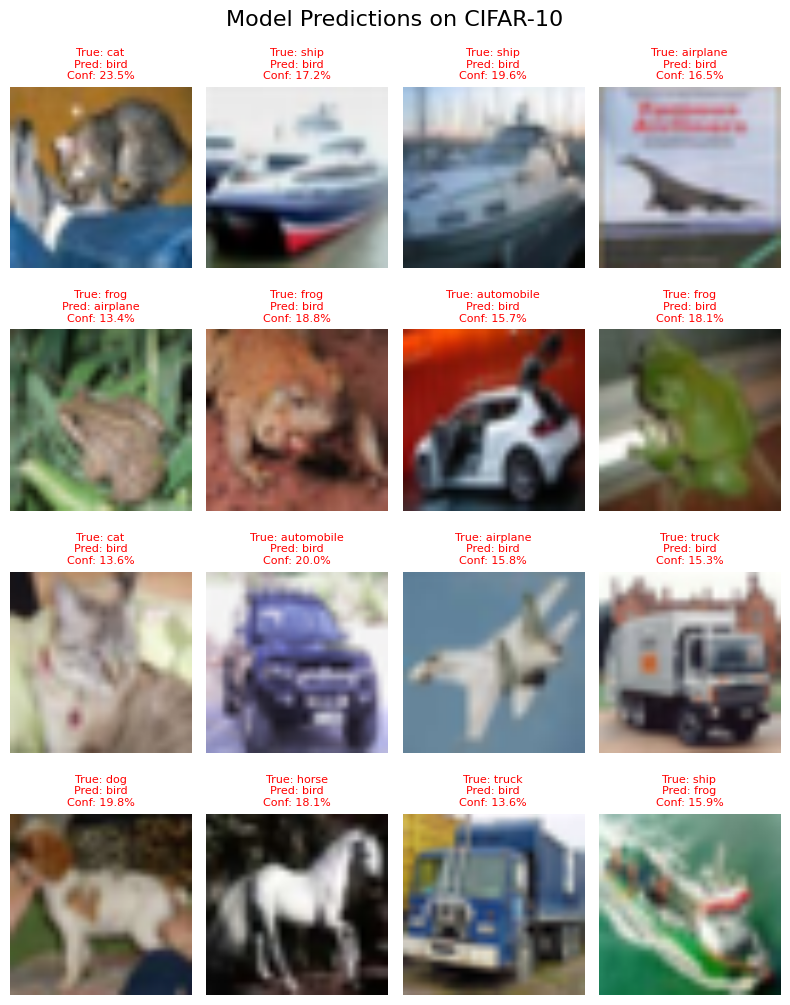

In [15]:
# 예측 결과 시각화 함수
def visualize_predictions(model, dataloader, device, num_images=16):
    """모델의 예측 결과를 시각화"""
    model.eval()

    # 이미지와 예측 결과 수집
    images, labels, predictions, probabilities = [], [], [], []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)

            outputs = model(data)
            if isinstance(outputs, tuple):
                outputs = outputs[0]

            probs = F.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            # CPU로 이동하여 저장
            images.extend(data.cpu())
            labels.extend(target.cpu())
            predictions.extend(preds.cpu())
            probabilities.extend(probs.cpu())

            if len(images) >= num_images:
                break

    # 시각화
    fig, axes = plt.subplots(4, 4, figsize=(8, 10))
    axes = axes.ravel()

    for i in range(min(num_images, len(images))):
        # 이미지 정규화 해제 (시각화용)
        img = images[i]
        img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
        img = torch.clamp(img, 0, 1)

        # 이미지 표시
        axes[i].imshow(img.permute(1, 2, 0))
        axes[i].axis('off')

        # 예측 결과 표시
        true_label = classes[labels[i]]
        pred_label = classes[predictions[i]]
        confidence = probabilities[i][predictions[i]] * 100

        color = 'green' if labels[i] == predictions[i] else 'red'
        title = f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%'
        axes[i].set_title(title, color=color, fontsize=8)

    plt.tight_layout()
    plt.suptitle('Model Predictions on CIFAR-10', fontsize=16, y=1.02)
    plt.show()

# 샘플 이미지로 예측 시각화
print("Visualizing predictions...")
visualize_predictions(pretrained_model, testloader, device, num_images=16)

Visualizing feature maps...
Sample image label: cat
Visualizing inception3a...


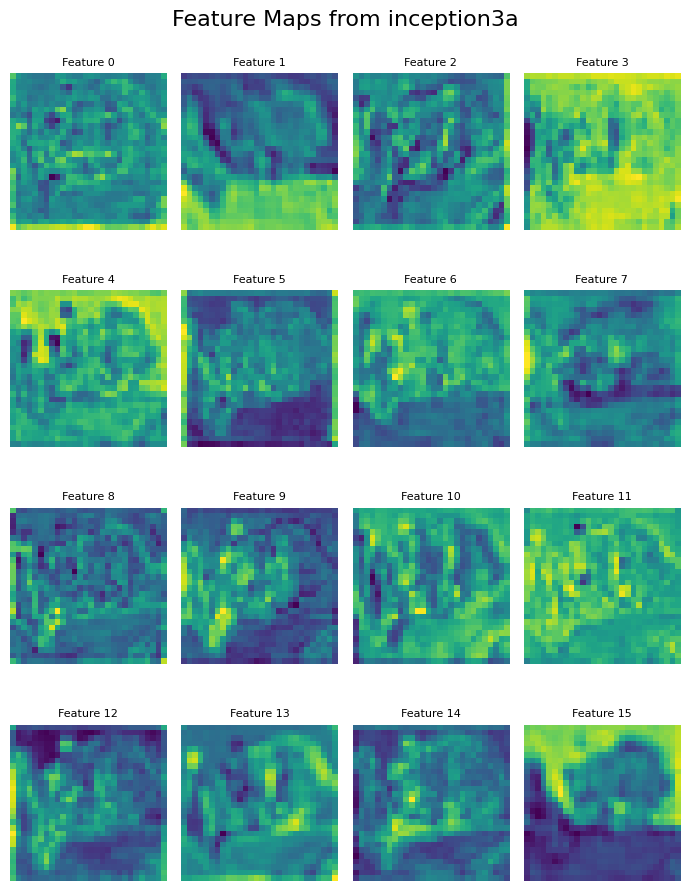

Visualizing inception4a...


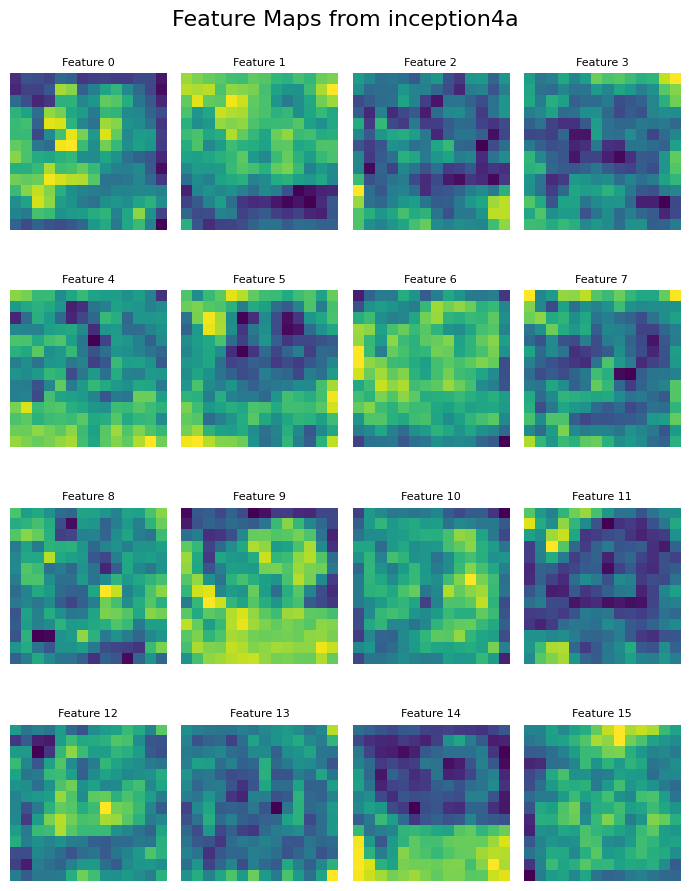

Visualizing inception5a...


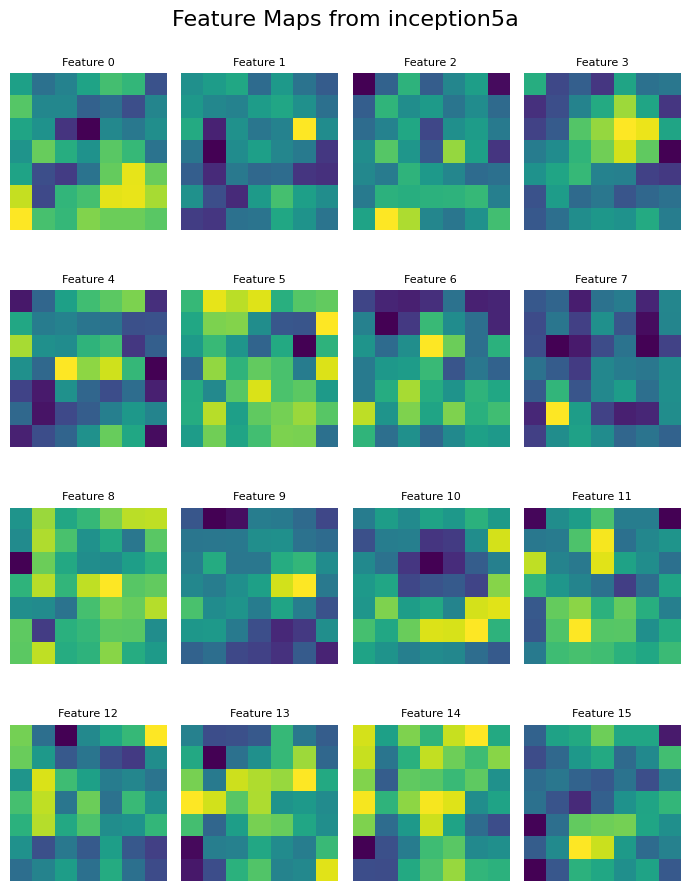

In [17]:
# Feature Map 시각화 함수
def visualize_feature_maps(model, image, layer_name, device, num_features=16):
    """특정 층의 Feature Map을 시각화"""
    model.eval()

    # Hook을 사용하여 중간층 출력 캡처
    feature_maps = {}

    def hook_fn(name):
        def hook(module, input, output):
            feature_maps[name] = output.detach()
        return hook

    # Hook 등록
    hooks = []
    for name, module in model.named_modules():
        if layer_name in name:
            hook = module.register_forward_hook(hook_fn(name))
            hooks.append(hook)

    # Forward pass
    image = image.unsqueeze(0).to(device)  # 배치 차원 추가
    with torch.no_grad():
        _ = model(image)

    # Hook 제거
    for hook in hooks:
        hook.remove()

    # Feature map 시각화
    if feature_maps:
        layer_output = list(feature_maps.values())[0]
        feature_map = layer_output[0]  # 첫 번째 이미지

        # 시각화할 feature map 수 제한
        num_features = min(num_features, feature_map.shape[0])

        fig, axes = plt.subplots(4, 4, figsize=(7, 9))
        axes = axes.ravel()

        for i in range(num_features):
            fmap = feature_map[i].cpu()
            axes[i].imshow(fmap, cmap='viridis')
            axes[i].axis('off')
            axes[i].set_title(f'Feature {i}', fontsize=8)

        # 빈 subplot 숨기기
        for i in range(num_features, 16):
            axes[i].axis('off')

        plt.tight_layout()
        plt.suptitle(f'Feature Maps from {layer_name}', fontsize=16, y=1.02)
        plt.show()
    else:
        print(f"Layer '{layer_name}' not found!")

# 샘플 이미지로 feature map 시각화
print("Visualizing feature maps...")
sample_image, sample_label = next(iter(testloader))
sample_image = sample_image[0]  # 첫 번째 이미지

print(f"Sample image label: {classes[sample_label[0]]}")

# 다양한 층의 feature map 시각화
layers_to_visualize = ['inception3a', 'inception4a', 'inception5a']

for layer_name in layers_to_visualize:
    print(f"Visualizing {layer_name}...")
    visualize_feature_maps(pretrained_model, sample_image, layer_name, device)

Analyzing Inception module branches...


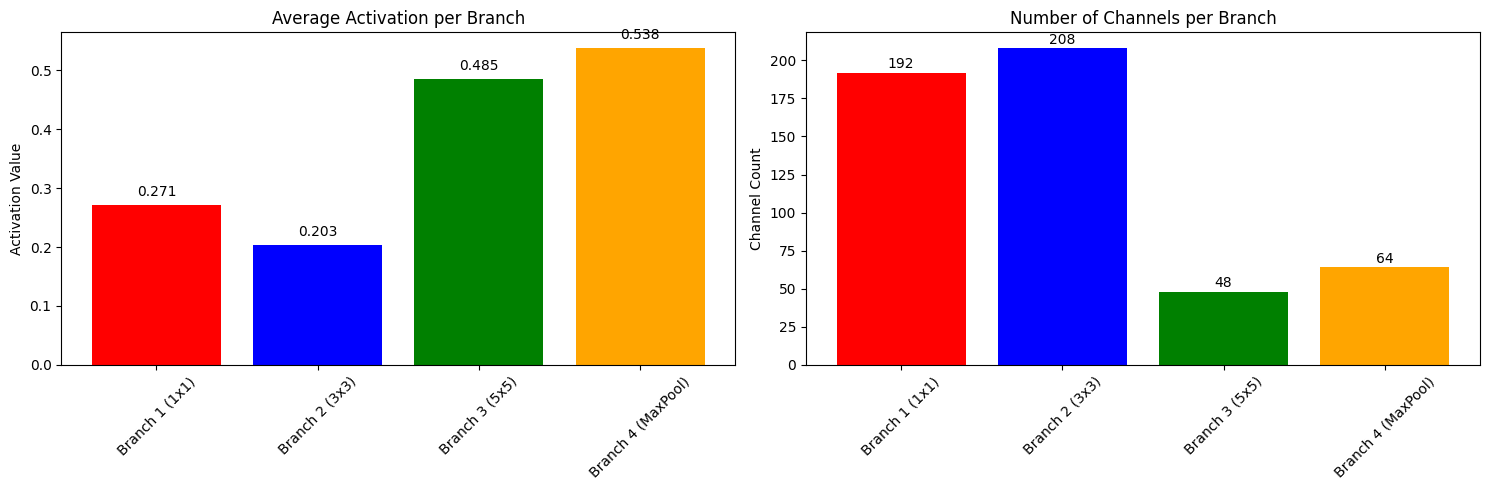


=== Branch Analysis Results ===
Branch 1 (1x1): 0.2711
Branch 2 (3x3): 0.2029
Branch 3 (5x5): 0.4853
Branch 4 (MaxPool): 0.5379

=== Channel Distribution ===
1x1 branch: 192 channels (37.5%)
3x3 branch: 208 channels (40.6%)
5x5 branch: 48 channels (9.4%)
MaxPool branch: 64 channels (12.5%)


In [18]:
# Inception 모듈의 branch별 활성화 분석
def analyze_inception_branches(model, image, device):
    """Inception 모듈의 각 branch 활성화를 분석"""
    model.eval()

    # inception4a 모듈에 접근
    inception_module = model.inception4a

    # 이미지를 inception4a까지 forward
    x = image.unsqueeze(0).to(device)

    with torch.no_grad():
        # inception4a 이전까지 forward
        x = F.relu(model.conv1(x))
        x = model.maxpool1(x)
        x = F.relu(model.conv2(x))
        x = F.relu(model.conv3(x))
        x = model.maxpool2(x)
        x = model.inception3a(x)
        x = model.inception3b(x)
        x = model.maxpool3(x)

        # inception4a의 각 branch별 출력
        branch1_out = F.relu(inception_module.branch1(x))
        branch2_out = F.relu(inception_module.branch2(x))
        branch3_out = F.relu(inception_module.branch3(x))
        branch4_out = F.relu(inception_module.branch4(x))

    # 각 branch의 평균 활성화 계산
    branch_activations = {
        'Branch 1 (1x1)': branch1_out.mean().item(),
        'Branch 2 (3x3)': branch2_out.mean().item(),
        'Branch 3 (5x5)': branch3_out.mean().item(),
        'Branch 4 (MaxPool)': branch4_out.mean().item()
    }

    # 시각화
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # 1. Branch별 평균 활성화 막대 그래프
    branches = list(branch_activations.keys())
    activations = list(branch_activations.values())

    bars = ax1.bar(branches, activations, color=['red', 'blue', 'green', 'orange'])
    ax1.set_title('Average Activation per Branch')
    ax1.set_ylabel('Activation Value')
    ax1.tick_params(axis='x', rotation=45)

    # 값 표시
    for bar, activation in zip(bars, activations):
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{activation:.3f}', ha='center', va='bottom')

    # 2. Branch별 채널 수 비교
    channel_counts = [
        branch1_out.shape[1],
        branch2_out.shape[1],
        branch3_out.shape[1],
        branch4_out.shape[1]
    ]

    bars2 = ax2.bar(branches, channel_counts, color=['red', 'blue', 'green', 'orange'])
    ax2.set_title('Number of Channels per Branch')
    ax2.set_ylabel('Channel Count')
    ax2.tick_params(axis='x', rotation=45)

    # 값 표시
    for bar, count in zip(bars2, channel_counts):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{count}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return branch_activations, channel_counts

# Inception branch 분석 실행
print("Analyzing Inception module branches...")
branch_acts, channel_counts = analyze_inception_branches(pretrained_model, sample_image, device)

print("\n=== Branch Analysis Results ===")
for branch, activation in branch_acts.items():
    print(f"{branch}: {activation:.4f}")

print("\n=== Channel Distribution ===")
total_channels = sum(channel_counts)
for i, (branch, count) in enumerate(zip(['1x1', '3x3', '5x5', 'MaxPool'], channel_counts)):
    percentage = count / total_channels * 100
    print(f"{branch} branch: {count} channels ({percentage:.1f}%)")

### Thread: Circuits을 읽을 때 주목할 점들

1. **Multi-scale Feature Detection**
   - 각 branch가 서로 다른 크기의 패턴을 감지
   - 어떤 feature가 어떤 branch에서 주로 활성화되는지

2. **Information Flow**
   - 1x1 conv의 차원 축소가 정보 흐름에 미치는 영향
   - Branch간 정보 결합 방식

3. **Hierarchical Representation**
   - 초기 층: edge, texture 같은 low-level feature
   - 중간 층: part, shape 같은 mid-level feature  
   - 후반 층: object, concept 같은 high-level feature

4. **Circuit Formation**
   - 특정 기능을 수행하는 뉴런들의 연결 패턴
   - Inception 모듈이 어떤 "회로"를 형성하는지

### 다음 단계

- **Feature Detector**: 각 뉴런이 감지하는 특정 패턴
- **Feature Visualization**: 뉴런이 "보고 있는" 것들
- **Circuit Analysis**: 뉴런들의 연결과 협력 방식
을 InceptionV1 구조와 연결해서 이해해보기